In [129]:
import pandas as pd
import numpy as np
import networkx as nx
#import geopandas
#from shapely.geometry import Point
import matplotlib.pyplot as plt
from sodapy import Socrata
from datetime import datetime

In [130]:
def getData(limit):
    client = Socrata("data.cityofnewyork.us", None)
    results = client.get("2yzn-sicd", limit = limit)
    results_df = pd.DataFrame.from_records(results)
    return results_df

In [131]:
taxi = getData(1000)

## Preprocessing: deleting zero columns and useless columns

In [132]:
def parseDate(dateStr):
    return datetime.strptime(dateStr.split(".")[0], "%Y-%m-%dT%H:%M:%S")

In [133]:
def preprocessDataRow(row):
    pickupDatetime = parseDate(row["pickup_datetime"])
    row["pickup_weekday"] = pickupDatetime.weekday()
    row["pickup_time"] = pickupDatetime.time()
    
    dropoffDatetime = parseDate(row["dropoff_datetime"])
    row["dropoff_weekday"] = dropoffDatetime.weekday()
    row["dropoff_time"] = dropoffDatetime.time()
    return row

In [134]:
taxi = taxi.apply(preprocessDataRow, axis = 1)

taxi["dropoff_latitude"] = taxi["dropoff_latitude"].astype('float64')
taxi["dropoff_longitude"] = taxi["dropoff_longitude"].astype('float64')
taxi["pickup_latitude"] = taxi["pickup_latitude"].astype('float64')
taxi["pickup_longitude"] = taxi["pickup_longitude"].astype('float64')
taxi["fare_amount"] = taxi["fare_amount"].astype('float64')
print(len(taxi))
#taxi.drop(taxi[
 #       (taxi.fare_amount >200)  
  #  ].index, inplace=True)

taxi_filtered = taxi
for i in range (len(taxi)) :
    if float(taxi_filtered.loc[i,'dropoff_latitude']) == 0 or float(taxi_filtered.loc[i,'dropoff_longitude']) == 0 or float(taxi_filtered.loc[i,'pickup_latitude']) == 0 or float(taxi_filtered.loc[i,'pickup_longitude']) == 0:
        taxi_filtered = taxi_filtered.drop(i)
coordinates = taxi_filtered[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']]
print(len(coordinates))

1000
989


### build tuples of dropoff and pickup

In [12]:
lol=coordinates
pickup=lol.drop(["dropoff_longitude","dropoff_latitude"],axis=1)
dropoff=lol.drop(["pickup_longitude","pickup_latitude"],axis=1)

In [13]:
tuples=pickup.itertuples(index=False)
pickup_tuples=np.array(list(tuples))
tuples=dropoff.itertuples(index=False)
dropoff_tuples=np.array(list(tuples))

In [14]:
pickup_tuples=pickup_tuples.astype('float64')
dropoff_tuples=dropoff_tuples.astype('float64')

In [15]:
print(len(np.unique(pickup_tuples,axis=0)))
print(len(pickup_tuples))
print(len(np.unique(pickup_tuples,axis=0)))
print(len(dropoff_tuples))

989
989
989
989


In [16]:
#round coordinates
pickup_tuples=pickup_tuples.round(2)
dropoff_tuples=dropoff_tuples.round(2)

In [162]:
print(len(np.unique(pickup_tuples,axis=0)))
print(len(pickup_tuples))
print(len(np.unique(pickup_tuples,axis=0)))
print(len(dropoff_tuples))

82
989
82
989


In [163]:
#invert coordinates so it fits with x and y axis
pickup_tuples_invert=[]
dropoff_tuples_invert=[]

for i in range(len(pickup_tuples)):
    #print(pickup_tuples[i])
    pickup_tuples_invert.append([pickup_tuples[i,1],pickup_tuples[i,0]])
pickup_tuples=np.array(pickup_tuples_invert)

for i in range(len(dropoff_tuples)):
    #print(dropoff_tuples[i])
    dropoff_tuples_invert.append([dropoff_tuples[i,1],dropoff_tuples[i,0]])
dropoff_tuples=np.array(dropoff_tuples_invert)

In [164]:
#create a list of tuples
pickup_list=[]
for i in range(len(pickup_tuples)):
    a=(pickup_tuples[i,0],pickup_tuples[i,1])
    pickup_list.append(a)
dropoff_list=[]
for i in range(len(dropoff_tuples)):
    a=(dropoff_tuples[i,0],dropoff_tuples[i,1])
    dropoff_list.append(a)

# safe coordinates as tuples in table
taxi_filtered['drop_off'] = dropoff_list
taxi_filtered['pick_up'] = pickup_list
del taxi_filtered['dropoff_latitude']
del taxi_filtered['dropoff_longitude']
del taxi_filtered['pickup_latitude']
del taxi_filtered['pickup_longitude']
taxi_filtered


,dropoff_datetime,extra,fare_amount,imp_surcharge,mta_tax,passenger_count,payment_type,pickup_datetime,ratecodeid,store_and_fwd_flag,tip_amount,tolls_amount,total_amount,trip_distance,vendor_id,drop_off,pick_up
0,2015-08-01T00:08:44.000,0.5,4.5,0.3,0.5,5,2,2015-08-01T00:05:30.000,1,N,0,0,5.8,0.79,2,"(-73.99, 40.77)","(-73.99, 40.76)"
1,2015-08-04T16:04:09.000,0,8,0.3,0.5,1,2,2015-08-04T15:55:20.000,1,N,0,0,8.8,1.6,1,"(-73.96, 40.78)","(-73.98, 40.78)"
2,2015-08-04T15:53:05.000,0,14,0.3,0.5,1,1,2015-08-04T15:32:16.000,1,N,2.95,0,17.75,1.9,1,"(-73.97, 40.75)","(-73.99, 40.74)"
3,2015-08-15T19:59:07.000,0,9,0.3,0.5,1,2,2015-08-15T19:47:51.000,1,N,0,0,9.8,1.9,1,"(-73.99, 40.72)","(-74.01, 40.71)"
5,2015-08-03T17:28:50.000,1,6.5,0.3,0.5,1,2,2015-08-03T17:21:48.000,1,N,0,0,8.3,1.01,2,"(-74.0, 40.75)","(-73.99, 40.74)"
6,2015-08-23T16:37:27.000,0,4.5,0.3,0.5,5,2,2015-08-23T16:33:15.000,1,N,0,0,5.3,0.62,2,"(-73.98, 40.76)","(-73.99, 40.75)"
7,2015-08-22T03:29:31.000,0.5,29.5,0.3,0.5,1,1,2015-08-22T02:54:27.000,1,N,7.7,0,38.5,7.2,1,"(-73.97, 40.68)","(-73.98, 40.73)"
8,2015-08-27T07:21:24.000,0,4,0.3,0.5,2,1,2015-08-27T07:19:10.000,1,N,1,0,5.8,0.64,2,"(-73.99, 40.73)","(-73.98, 40.74)"
9,2015-08-02T19:56:25.000,0,15,0.3,0.5,3,1,2015-08-02T19:36:36.000,1,N,0,0,15.8,3.42,2,"(-74.0, 40.72)","(-73.98, 40.75)"
10,2015-08-07T22:03:07.000,0.5,9.5,0.3,0.5,1,2,2015-08-07T21:53:17.000,1,N,0,0,10.8,1.96,2,"(-73.98, 40.78)","(-73.97, 40.76)"


In [165]:
#create edges by linking dropoffs to pickups
edges=[]
for i in range(len(pickup_list)):
    edges.append((pickup_list[i],dropoff_list[i]))

In [166]:
# delete identical edges as well as grab the count of edges for coloring
edges,index=np.unique(np.array(edges),axis=0,return_counts=True)

In [167]:
#grab the maximum number of the same edge to make classes of edge counts
count=max(index)
print(a)

(-73.98, 40.75)


In [168]:
index[index<=(count/2)]=0
index[index>(count/2)]=1
#index=index[index>=(a/2)]

In [169]:
#build color array
colors=[]
for i in range(len(index)):
    if index[i]==1:
        colors.append("r")
    else:
        colors.append("b")

## Graph of whole area

In [170]:
#build graph
g=nx.Graph()
#g=nx.DiGraph()

In [171]:
#build a list of nodes from pickup and arrival and make it distinct
node_list=[]
for i in range(len(pickup_list)):
    node_list.append(pickup_list[i])
for i in range(len(dropoff_list)):
    node_list.append(dropoff_list[i])
print(len(node_list))
node_list=list(set(node_list))
print(len(node_list))
g.add_nodes_from(node_list)

1978
154


In [172]:
# transform edge array into tuple form for adding it to graph
edge_tuples=[]
for i in range(len(edges)):
    edge_tuples.append(((edges[i,0,0],edges[i,0,1]),(edges[i,1,0],edges[i,1,1])))
g.add_edges_from(edge_tuples)

In [173]:
#build the position array by mapping the name of the tuple to the coordinates
position = {}
for i in range(len(node_list)):
    position.update({node_list[i]:node_list[i]})

In [174]:
nx.average_clustering(g)

0.24744955875666386

In [175]:
#set the size of the plot
plt.rcParams["figure.figsize"] = (20,10)

/Users/niclas/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


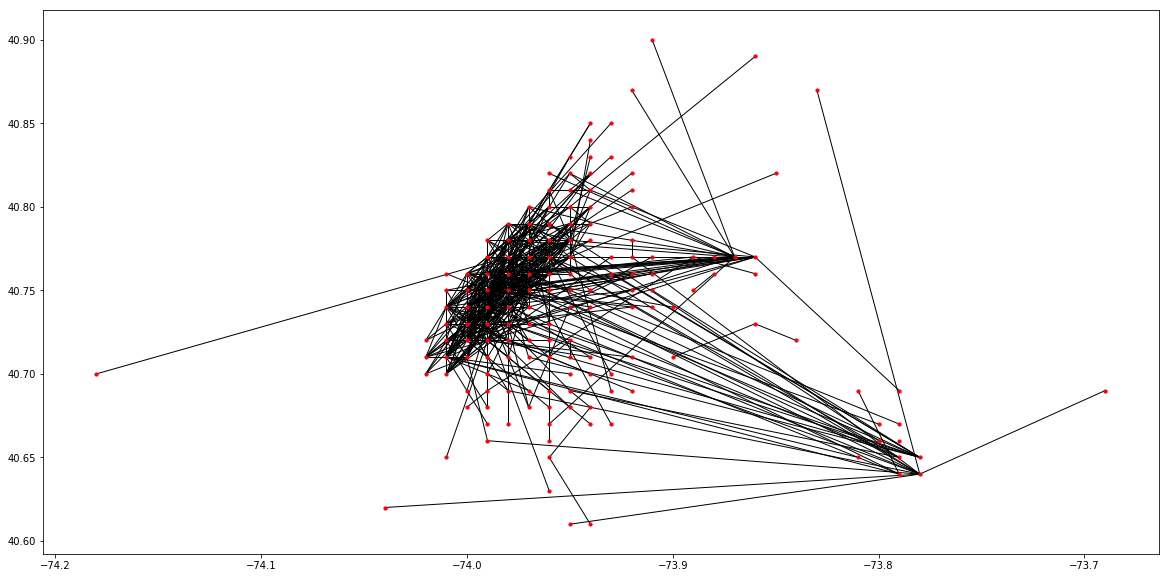

In [176]:
nx.draw_networkx(g, node_size = 10,with_labels=False,pos=position)

## Graph of only the center region

In [43]:
g_center=nx.DiGraph()

In [44]:
center_nodes=[]
for i in node_list:    
    if i[0]<-74.1 or i[0]>-73.9 or i[1]<40.65 or i[0]>40.85:
        pass
    else:
        center_nodes.append(i)   
g_center.add_nodes_from(center_nodes)

In [47]:
center_edges=[]
for i in edge_tuples:
    if i[0][0]<-74.1 or i[0][0]>-73.9 or i[0][1]<40.65 or i[0][1]>40.85:
        pass
    else:
        if i[1][0]<-74.1 or i[1][0]>-73.9 or i[1][1]<40.65 or i[1][1]>40.85:
            pass
        else:
            center_edges.append(i)
g_center.add_edges_from(center_edges)
print(len(center_edges))

84


In [48]:
center_position = {}
a=list(g_center.nodes)
for i in range(len(a)):
    center_position.update({a[i]:a[i]})
print(len(center_position))

56


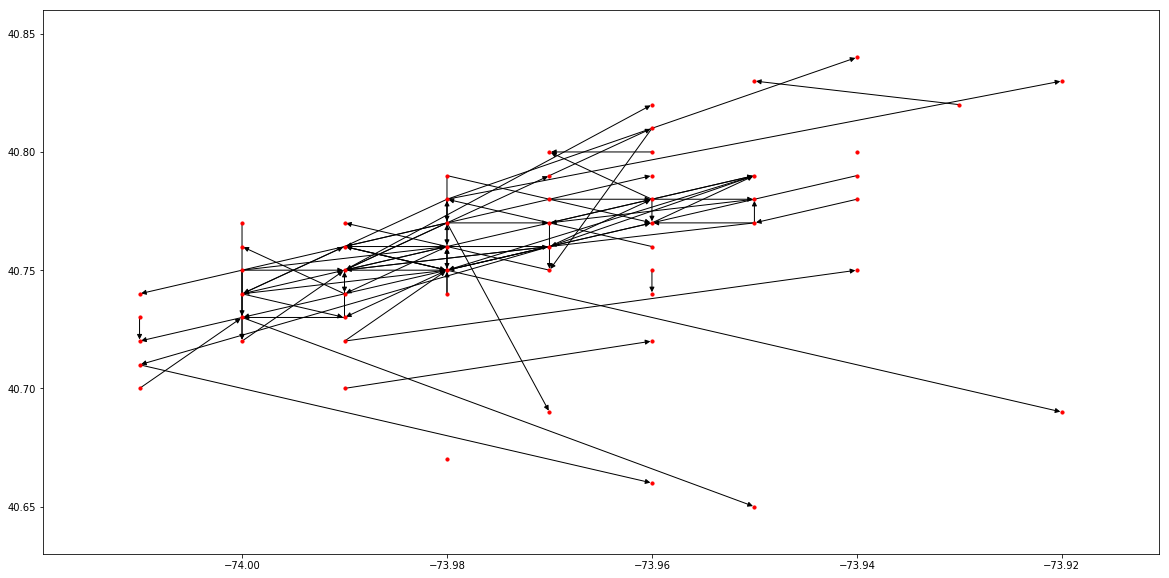

In [49]:
nx.draw_networkx(g_center, node_size = 10,with_labels=False,pos=center_position)

## experimental stuff

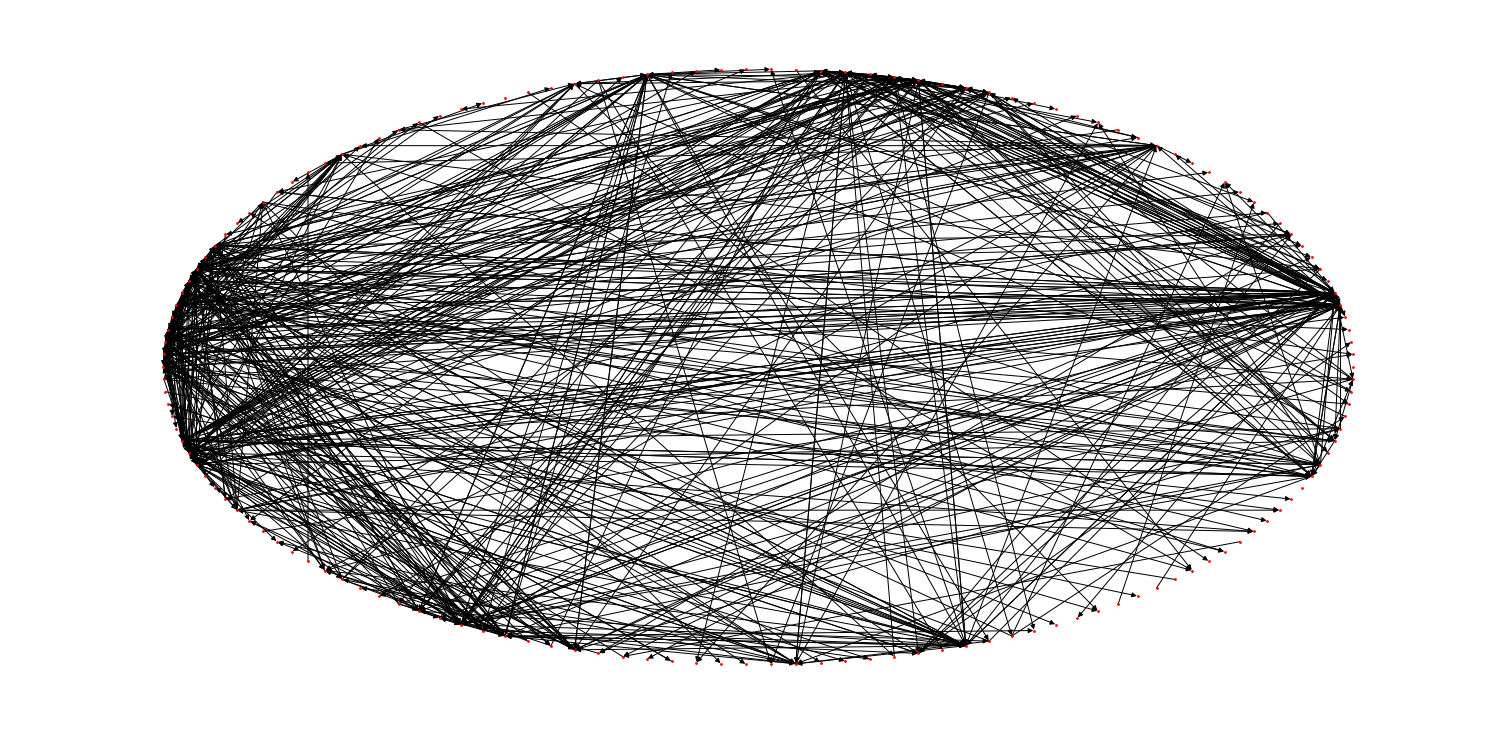

In [263]:
nx.draw_circular(g,node_size=3)

In [177]:
from networkx.algorithms import community

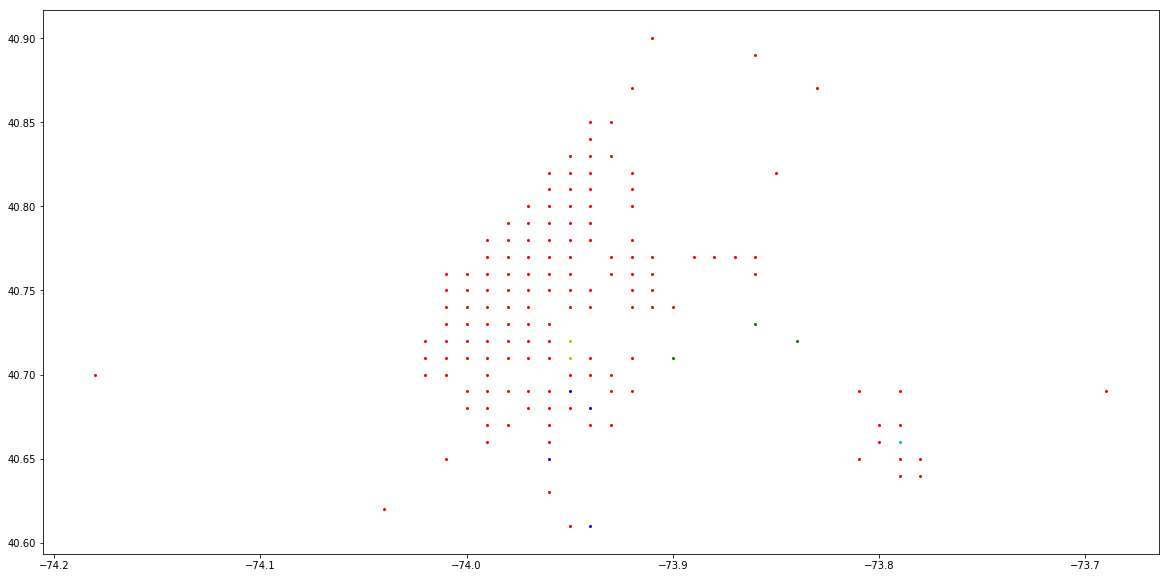

In [178]:
# this does not really work 

communities_generator = community.girvan_newman(g)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
com = sorted(map(sorted, next_level_communities))
#nx.draw_networkx_nodes(G,pos,nodelist=com[2],node_color='b',node_size=1,alpha=0.8)
#position
#nx.draw_networkx(g, node_size = 1,pos=position,with_labels=False)
nx.draw_networkx_nodes(g,position,nodelist=com[0],node_color='r',node_size=4,with_labels=False)
nx.draw_networkx_nodes(g,position,nodelist=com[1],node_color='b',node_size=4,with_labels=False)
nx.draw_networkx_nodes(g,position,nodelist=com[2],node_color='y',node_size=4,with_labels=False)
nx.draw_networkx_nodes(g,position,nodelist=com[3],node_color='g',node_size=4,with_labels=False)
nx.draw_networkx_nodes(g,position,nodelist=com[4],node_color='w',node_size=4,with_labels=False)
nx.draw_networkx_nodes(g,position,nodelist=com[5],node_color='c',node_size=4,with_labels=False)

#nx.draw_networkx_edges(g,node_size = 1,pos=position)

In [179]:
# this works only on undirected graphs

c = list(community.greedy_modularity_communities(g))
# number of identified communitiess
print(len(c))
#nx.draw_networkx_nodes(g,position, node_size=4,with_labels=False) #draw all nodes

13


In [180]:
taxi_filtered

,dropoff_datetime,extra,fare_amount,imp_surcharge,mta_tax,passenger_count,payment_type,pickup_datetime,ratecodeid,store_and_fwd_flag,tip_amount,tolls_amount,total_amount,trip_distance,vendor_id,drop_off,pick_up
0,2015-08-01T00:08:44.000,0.5,4.5,0.3,0.5,5,2,2015-08-01T00:05:30.000,1,N,0,0,5.8,0.79,2,"(-73.99, 40.77)","(-73.99, 40.76)"
1,2015-08-04T16:04:09.000,0,8,0.3,0.5,1,2,2015-08-04T15:55:20.000,1,N,0,0,8.8,1.6,1,"(-73.96, 40.78)","(-73.98, 40.78)"
2,2015-08-04T15:53:05.000,0,14,0.3,0.5,1,1,2015-08-04T15:32:16.000,1,N,2.95,0,17.75,1.9,1,"(-73.97, 40.75)","(-73.99, 40.74)"
3,2015-08-15T19:59:07.000,0,9,0.3,0.5,1,2,2015-08-15T19:47:51.000,1,N,0,0,9.8,1.9,1,"(-73.99, 40.72)","(-74.01, 40.71)"
5,2015-08-03T17:28:50.000,1,6.5,0.3,0.5,1,2,2015-08-03T17:21:48.000,1,N,0,0,8.3,1.01,2,"(-74.0, 40.75)","(-73.99, 40.74)"
6,2015-08-23T16:37:27.000,0,4.5,0.3,0.5,5,2,2015-08-23T16:33:15.000,1,N,0,0,5.3,0.62,2,"(-73.98, 40.76)","(-73.99, 40.75)"
7,2015-08-22T03:29:31.000,0.5,29.5,0.3,0.5,1,1,2015-08-22T02:54:27.000,1,N,7.7,0,38.5,7.2,1,"(-73.97, 40.68)","(-73.98, 40.73)"
8,2015-08-27T07:21:24.000,0,4,0.3,0.5,2,1,2015-08-27T07:19:10.000,1,N,1,0,5.8,0.64,2,"(-73.99, 40.73)","(-73.98, 40.74)"
9,2015-08-02T19:56:25.000,0,15,0.3,0.5,3,1,2015-08-02T19:36:36.000,1,N,0,0,15.8,3.42,2,"(-74.0, 40.72)","(-73.98, 40.75)"
10,2015-08-07T22:03:07.000,0.5,9.5,0.3,0.5,1,2,2015-08-07T21:53:17.000,1,N,0,0,10.8,1.96,2,"(-73.98, 40.78)","(-73.97, 40.76)"


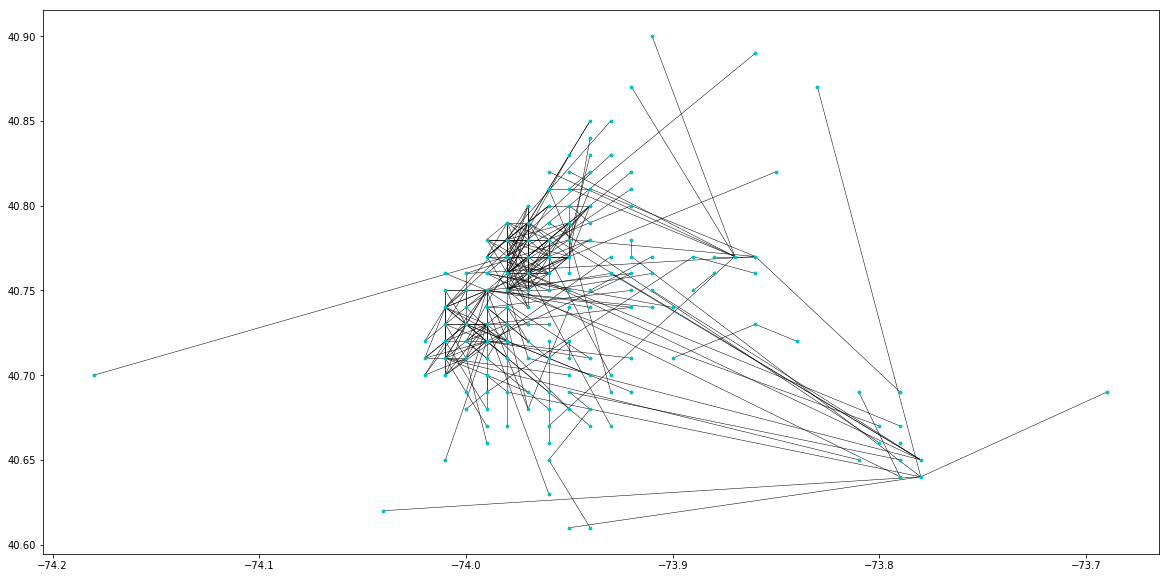

In [184]:
# com = all nodess in community 

com_edges = list()
fares = list()
start_dates = list()
end_dates = list()

for i in range(len(c)):
    com = [tuple(x) for x in c[i]]

    com_edges_i = list()
    fares_i = list()
    start_dates_i = list()
    end_dates_i = list()
    
    # get all edges(trips) only within nodes in community 1 and price and time of trips
    # (edges with end and start point in community 1)
    for e in g.edges:
        if tuple(e[0]) in set(com) and tuple(e[1]) in set(com):
            com_edges_i.append(e)
            fares_i += list(map(lambda x: float(x),(taxi_filtered.loc[ list(taxi_filtered[  (taxi_filtered['pick_up']==e[0]) & (taxi_filtered['drop_off']==e[1]) ].index), 'fare_amount' ])))
            start_dates_i += list((taxi_filtered.loc[ list(taxi_filtered[  (taxi_filtered['pick_up']==e[0]) & (taxi_filtered['drop_off']==e[1]) ].index), 'pickup_datetime' ]))
            end_dates_i += list((taxi_filtered.loc[ list(taxi_filtered[  (taxi_filtered['pick_up']==e[0]) & (taxi_filtered['drop_off']==e[1]) ].index), 'dropoff_datetime' ]))
    com_edges.append(com_edges_i)
    fares.append(fares_i)
    start_dates.append(start_dates_i)
    end_dates.append(end_dates_i)
    
    # draw all nodes of community 1 and all edges within those nodes
    nx.draw_networkx(g,position,nodelist=com,edgelist=com_edges_i,node_color='c',node_size=8,with_labels=False, width=0.5)

In [9]:
fares_new=[]

for i in fares:
    fares_local=[]
    for j in i:
        if j ==300:
            print("gefunden")
        else:
            fares_local.append()
    fares_new.append(fares_local)

NameError: name 'fares' is not defined

In [183]:
# draw all nodes of community 1 and all edges within those nodes
print(fares)
print(start_dates)
print(end_dates)

[[10.5, 5.0, 7.0, 8.0, 7.0, 10.0, 11.0, 5.5, 6.0, 3.0, 4.0, 7.5, 6.0, 8.0, 19.0, 5.5, 5.0, 4.5, 6.5, 6.0, 5.0, 7.0, 4.5, 6.0, 12.5, 22.0, 16.5, 9.5, 13.5, 12.5, 9.0, 7.5, 11.5, 11.5, 10.5, 9.0, 22.5, 9.0, 11.0, 4.0, 5.0, 4.0, 5.5, 4.0, 13.5, 20.5, 16.5, 24.0, 52.0, 8.0, 10.5, 11.0, 21.5, 9.5, 8.0, 4.5, 14.0, 13.5, 27.0, 10.5, 9.0, 7.0, 8.5, 12.5, 3.5, 15.5, 13.5, 7.0, 7.5, 9.0, 5.0, 10.5, 4.0, 7.0, 5.0, 7.5, 4.0], [52.0, 9.0, 5.5, 7.0, 6.5, 4.0, 3.5, 14.0, 6.0, 8.5, 6.0, 5.0, 5.0, 3.5, 8.0, 8.0, 4.0, 5.5, 7.0, 9.0, 5.5, 4.0, 5.5, 7.5, 6.0, 10.5, 37.5, 4.5, 3.5, 5.5, 9.5, 3.0, 4.0, 7.0, 7.5, 12.5, 9.5, 6.5, 10.5, 5.5, 5.0, 9.5, 17.0, 12.5, 10.5, 11.5, 11.5, 11.0, 12.0, 11.5, 14.0, 5.0, 9.5, 8.5, 15.0, 12.5, 7.0, 19.0, 12.5, 10.0, 6.0, 4.0, 6.5, 10.0, 3.5, 6.0, 10.5, 11.5, 6.5, 5.5, 300.0, 5.5, 6.0, 7.5, 10.0, 7.5, 9.5, 9.5, 4.5, 5.5, 7.0, 7.0, 6.5, 6.5, 6.5, 13.5, 4.0, 12.0, 8.0, 8.0, 8.0, 10.5, 11.0, 12.0, 10.0, 18.5, 8.0, 4.5, 9.0, 9.0, 7.0, 9.0, 9.0, 8.5, 9.0, 13.5, 19.5, 8.0, 4.5, 3

[10.5, 6.0, 10.5, 7.5, 18.5, 7.0, 12.5]
['2015-03-09T15:46:48.000', '2015-01-23T12:05:44.000', '2015-06-17T09:40:53.000', '2015-01-02T23:00:10.000', '2015-03-02T06:27:20.000', '2015-01-11T11:00:05.000', '2015-05-12T13:08:16.000']
['2015-03-09T15:58:58.000', '2015-01-23T12:12:44.000', '2015-06-17T09:55:43.000', '2015-01-02T23:09:18.000', '2015-03-02T06:40:55.000', '2015-01-11T11:06:58.000', '2015-05-12T13:27:37.000']


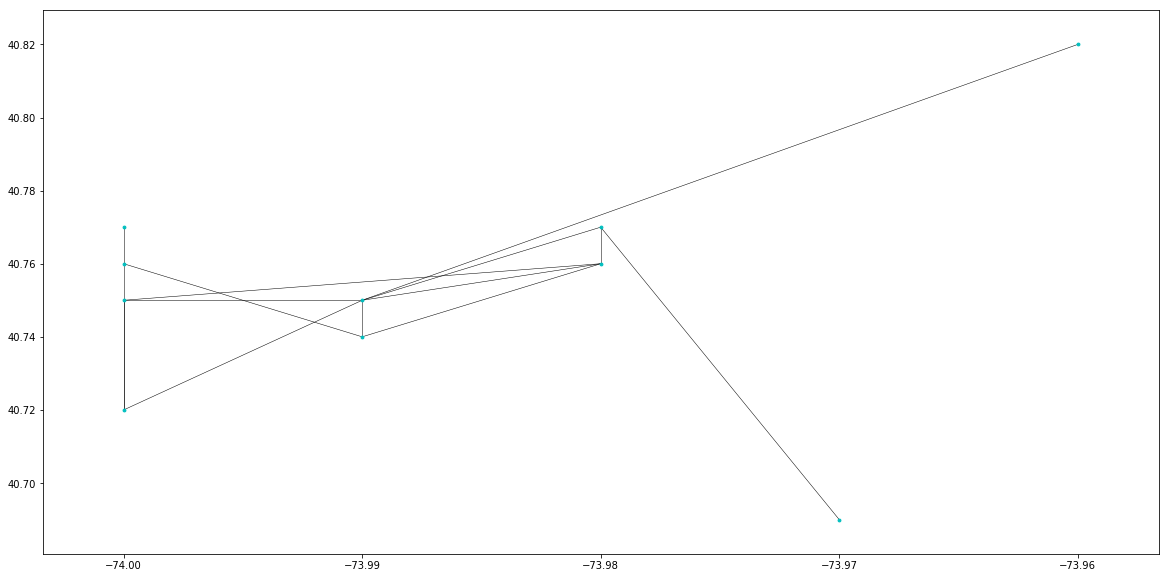

In [85]:
# same for second community
com = [tuple(x) for x in c[2]]

com_2_edges = list()
fares = list()
start_dates = list()
end_dates = list()

# get all edges within nodes in community 1 and price and time of trips
for e in g.edges:
    if tuple(e[0]) in set(com) and tuple(e[1]) in set(com):
        com_2_edges.append(e)
        fares += list(map(lambda x: float(x),(taxi_filtered.loc[ list(taxi_filtered[  (taxi_filtered['pick_up']==e[0]) & (taxi_filtered['drop_off']==e[1]) ].index), 'fare_amount' ])))
        start_dates += list((taxi_filtered.loc[ list(taxi_filtered[  (taxi_filtered['pick_up']==e[0]) & (taxi_filtered['drop_off']==e[1]) ].index), 'pickup_datetime' ]))
        end_dates += list((taxi_filtered.loc[ list(taxi_filtered[  (taxi_filtered['pick_up']==e[0]) & (taxi_filtered['drop_off']==e[1]) ].index), 'dropoff_datetime' ]))

nx.draw_networkx(g,position,nodelist=com,edgelist=com_2_edges,node_color='c',node_size=8,with_labels=False, width=0.5)

print(fares)
print(start_dates)
print(end_dates)

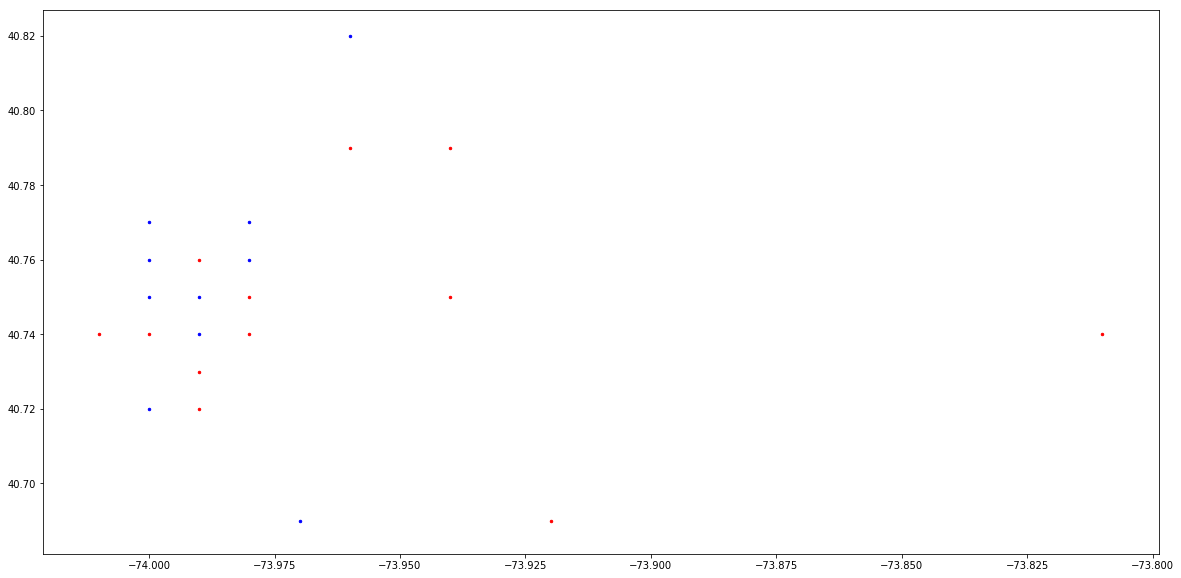

In [86]:
c = list(community.greedy_modularity_communities(g))
com = [tuple(x) for x in c[1]]
nx.draw_networkx_nodes(g,position,nodelist=com,node_color='r',node_size=6,with_labels=False)

com = [tuple(x) for x in c[2]]
nx.draw_networkx_nodes(g,position,nodelist=com,node_color='b',node_size=6,with_labels=False)

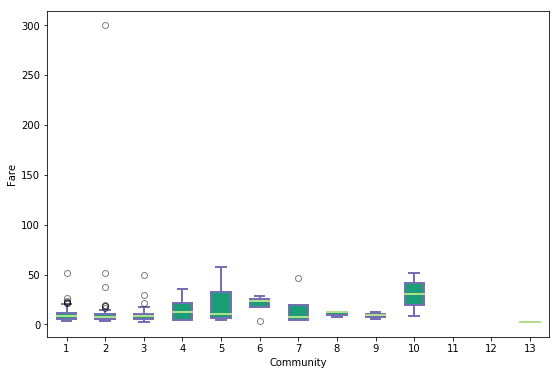

In [186]:
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)
ax.set_xlabel('Community')
ax.set_ylabel('Fare')

bp = ax.boxplot(fares, patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)

In [187]:
fares

[[10.5,
  5.0,
  7.0,
  8.0,
  7.0,
  10.0,
  11.0,
  5.5,
  6.0,
  3.0,
  4.0,
  7.5,
  6.0,
  8.0,
  19.0,
  5.5,
  5.0,
  4.5,
  6.5,
  6.0,
  5.0,
  7.0,
  4.5,
  6.0,
  12.5,
  22.0,
  16.5,
  9.5,
  13.5,
  12.5,
  9.0,
  7.5,
  11.5,
  11.5,
  10.5,
  9.0,
  22.5,
  9.0,
  11.0,
  4.0,
  5.0,
  4.0,
  5.5,
  4.0,
  13.5,
  20.5,
  16.5,
  24.0,
  52.0,
  8.0,
  10.5,
  11.0,
  21.5,
  9.5,
  8.0,
  4.5,
  14.0,
  13.5,
  27.0,
  10.5,
  9.0,
  7.0,
  8.5,
  12.5,
  3.5,
  15.5,
  13.5,
  7.0,
  7.5,
  9.0,
  5.0,
  10.5,
  4.0,
  7.0,
  5.0,
  7.5,
  4.0],
 [52.0,
  9.0,
  5.5,
  7.0,
  6.5,
  4.0,
  3.5,
  14.0,
  6.0,
  8.5,
  6.0,
  5.0,
  5.0,
  3.5,
  8.0,
  8.0,
  4.0,
  5.5,
  7.0,
  9.0,
  5.5,
  4.0,
  5.5,
  7.5,
  6.0,
  10.5,
  37.5,
  4.5,
  3.5,
  5.5,
  9.5,
  3.0,
  4.0,
  7.0,
  7.5,
  12.5,
  9.5,
  6.5,
  10.5,
  5.5,
  5.0,
  9.5,
  17.0,
  12.5,
  10.5,
  11.5,
  11.5,
  11.0,
  12.0,
  11.5,
  14.0,
  5.0,
  9.5,
  8.5,
  15.0,
  12.5,
  7.0,
  19.0,
  12.5